# IMPORT DEPENDENCIES

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.preprocessing import LabelEncoder
import time
import shutil
import pathlib
import itertools
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.metrics import Precision, Recall, AUC
from google.colab import runtime

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LOADING DATA

In [3]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
categories = ["Normal","Osteopenia", "Osteoporosis"]

In [4]:
TfDatasetsPath = '/content/drive/MyDrive/CSEN-240-Project/TfDatasets'
# TfDatasetsPath = 'TfDatasets'

In [5]:
trainDataset = tf.data.Dataset.load(TfDatasetsPath + "/trainDataset")
validDataset = tf.data.Dataset.load(TfDatasetsPath + "/validDataset")
testDataset = tf.data.Dataset.load(TfDatasetsPath + "/testDataset")

In [6]:
def augment(image, label):
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_flip_up_down(image)
    image - tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

In [7]:
augmentedDataset = trainDataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
trainDataset = trainDataset.concatenate(augmentedDataset)

In [8]:
len(trainDataset), len(validDataset), len(testDataset)

(6048, 378, 378)

In [9]:
trainDataset = trainDataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
validDataset = validDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
testDataset = testDataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
trainDataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [11]:
metrics = [Precision(), Recall(), AUC(), 'accuracy']

# DenseNet201 Model

In [12]:
def createModel(input_shape, num_classes=3, learning_rate=1e-4):
    inputs = tf.keras.layers.Input(shape=input_shape, name="Input_Layer")
    base_model = tf.keras.applications.DenseNet201(weights="imagenet", input_tensor=inputs, include_top=False)
    base_model.trainable = False
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D(name="Global_Average_Pooling")(x)
    x = tf.keras.layers.Dense(512, activation="relu", name="FC_512")(x)
    x = tf.keras.layers.BatchNormalization(name="Batch_Normalization2")(x)
    x = tf.keras.layers.Dropout(0.25, name="Dropout1")(x)
    x = tf.keras.layers.Dense(256, activation="relu", name="FC_256")(x)
    x = tf.keras.layers.BatchNormalization(name="Batch_Normalization3")(x)
    x = tf.keras.layers.Dropout(0.25, name="Dropout2")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax",name="Output_Layer")(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
    return model

# TRAINING

In [13]:
input_shape = (224, 224, 3)
model = createModel(input_shape, num_classes=3, learning_rate=1e-4)

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [14]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ Input_Layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 19,440,707 (74.16 MB)

 Trainable params: 1,117,187 (4.26 MB)

 Non-trainable params: 18,323,520 (69.90 MB)

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

In [16]:
# Defining The ReduceLRonPlateau Callback
reduceLRCallback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.8, # How much to improve the learning rate -> LR = LR*factor
    patience=3,
    verbose=1,
    mode='max',
    min_delta=0.0001, # Change in metric below this delta is considered as no change
    cooldown=0, # Number of epochs to wait before resuming normal operation after lr has been improved
    min_lr=0 # Learning Rate won't go below this
)

In [17]:
history = model.fit(trainDataset,
                        validation_data=validDataset,
                        epochs=250,
                        callbacks=[early_stopping, reduceLRCallback],
                        verbose=1)

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 132s 363ms/step - accuracy: 0.5105 - auc: 0.6961 - loss: 1.2427 - precision: 0.5265 - recall: 0.4667 - val_accuracy: 0.6534 - val_auc: 0.8148 - val_loss: 0.8271 - val_precision: 0.6748 - val_recall: 0.5820 - learning_rate: 1.0000e-04
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - accuracy: 0.6558 - auc: 0.8324 - loss: 0.8337 - precision: 0.6766 - recall: 0.6175 - val_accuracy: 0.6587 - val_auc: 0.8287 - val_loss: 0.8473 - val_precision: 0.6818 - val_recall: 0.6349 - learning_rate: 1.0000e-04
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.6935 - auc: 0.8617 - loss: 0.7414 - precision: 0.7213 - recall: 0.6625 - val_accuracy: 0.6852 - val_auc: 0.8613 - val_loss: 0.7433 - val_precision: 0.6991 - val_recall: 0.6455 - learning_rate: 1.0000e-04
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.7356 - auc: 0.8917 - loss: 0.6422 - precision: 0.7569 - recall: 0.7029 - val_accuracy: 0.7011 - val_auc: 0.8724 -

# FINE-TUNING

In [18]:
for layer in model.layers[1:-8]:
    layer.trainable = True

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6), loss="categorical_crossentropy", metrics=metrics)

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ Input_Layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 19,440,707 (74.16 MB)

 Trainable params: 19,210,115 (73.28 MB)

 Non-trainable params: 230,592 (900.75 KB)

In [21]:
history = model.fit( trainDataset,
                         validation_data=validDataset,
                         epochs=250,
                         callbacks=[early_stopping, reduceLRCallback],
                         verbose=1)

Epoch 1/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 443s 324ms/step - accuracy: 0.5280 - auc: 0.7543 - loss: 1.4988 - precision: 0.5841 - recall: 0.5556 - val_accuracy: 0.5767 - val_auc: 0.8007 - val_loss: 1.2138 - val_precision: 0.5831 - val_recall: 0.5661 - learning_rate: 5.0000e-06
Epoch 2/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.6947 - auc: 0.8625 - loss: 0.8276 - precision: 0.7087 - recall: 0.6765 - val_accuracy: 0.6402 - val_auc: 0.8118 - val_loss: 1.1685 - val_precision: 0.6477 - val_recall: 0.6323 - learning_rate: 5.0000e-06
Epoch 3/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.7553 - auc: 0.9076 - loss: 0.6306 - precision: 0.7675 - recall: 0.7404 - val_accuracy: 0.6561 - val_auc: 0.8420 - val_loss: 1.0723 - val_precision: 0.6685 - val_recall: 0.6508 - learning_rate: 5.0000e-06
Epoch 4/250
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.7913 - auc: 0.9295 - loss: 0.5299 - precision: 0.8061 - recall: 0.7732 - val_accuracy: 0.6931 - val_auc: 0.

# PLOTS

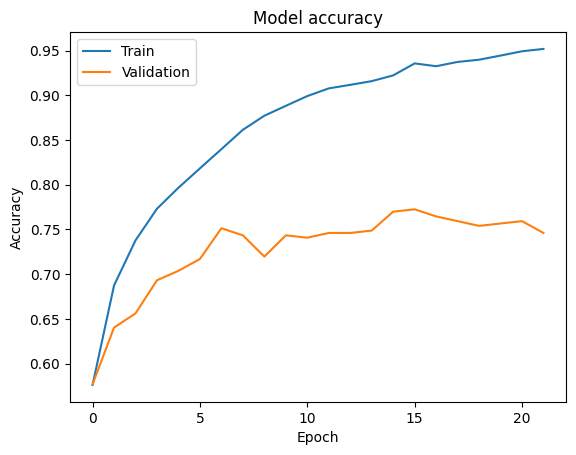

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

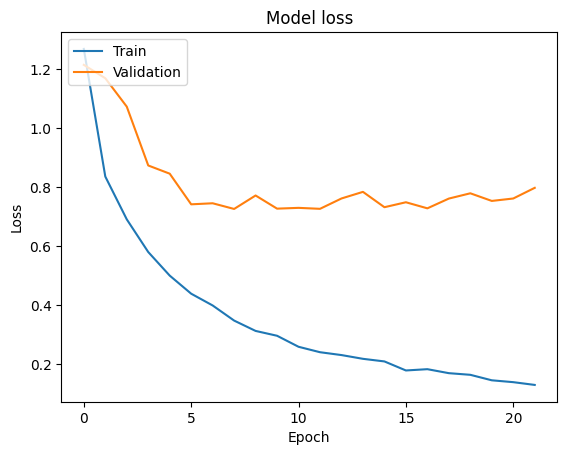

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [24]:
valid_labels = []
for xBatch, yBatch in validDataset:
    valid_labels.extend(np.argmax(yBatch, axis=1))
predictions = model.predict(validDataset)
predicted_classes = np.argmax(predictions, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step


In [25]:
def ppo_loss(y_true, y_pred):
    epsilon = 0.2
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    selected_probs = tf.reduce_sum(y_pred * y_true_one_hot, axis=-1)
    old_selected_probs = tf.reduce_sum(tf.stop_gradient(y_pred) * y_true_one_hot, axis=-1)
    ratio = selected_probs / (old_selected_probs + 1e-10)
    clipped_ratio = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon)
    loss = -tf.reduce_mean(tf.minimum(ratio, clipped_ratio))
    return loss

In [26]:
ppo_loss_value = ppo_loss(valid_labels, predictions)
print("\nPPO Loss on Validation Data:", ppo_loss_value.numpy())


PPO Loss on Validation Data: -1.0


# TESTING

In [27]:
test_labels = []
for xBatch, yBatch in testDataset:
    test_labels.extend(np.argmax(yBatch, axis=1))
predictions = model.predict(testDataset)
predicted_classes = np.argmax(predictions, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [28]:
report = classification_report(test_labels, predicted_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

      Normal       0.85      0.80      0.82       126
  Osteopenia       0.76      0.83      0.79       126
Osteoporosis       0.79      0.76      0.77       126

    accuracy                           0.80       378
   macro avg       0.80      0.80      0.80       378
weighted avg       0.80      0.80      0.80       378



Text(95.72222222222221, 0.5, 'True Label')

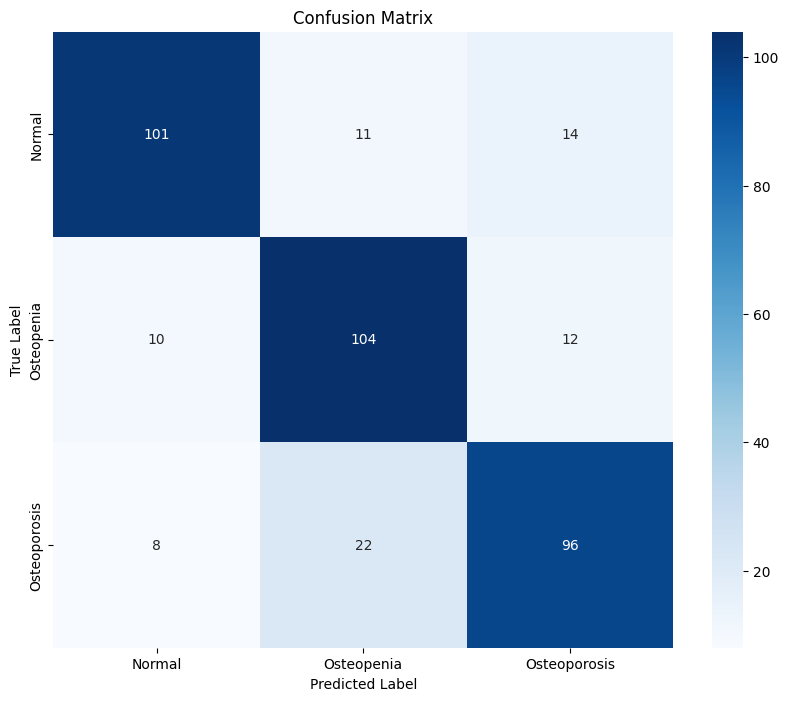

In [29]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [30]:
runtime.unassign()